# Декомпозиция проекта
«Метанпромбанк» — деньги не пахнут!

<b>Первично поставленная задача:</b> проанализировать клиентов банка и выделить портрет клиентов, склонных к оттоку.
* <b>Чего хотят достичь и зачем?</b> Может требуется прогнозирующий алгоритм!?
* <b>Кто заинтересован в результате вашей работы?</b> Директор, менеджер, аналитик, маркетолог!?
* <b>Какие решения будут предприняты на основании вашего анализа?</b> Перестройка политики, отношения банка к клиентам или увеличение лояльности клиентов!?


Возможно задача формулируется конкретнее: На основании действий и активности клиентов, выделить портреты типичных пользователей и выявить портреты склонные к оттоку. 

Возможно потребуется проверить некоторые гипотезы:
* Взаимосвязь активности клиента и оттока
* Зависимость количества продуктов открытых в банке и вероятность ухода
* Связь между баллами кредитного скоринга и вероятностью оттока
* Влияние кредитной карты на вероятность оттока
* Влияние благосостояние клиента и вероятность оттока


Последнее подробнее можно разделить на подзадачи:
* Разделить клиентов на некоторое количество групп в зависимости от заработной платы, количество объектов в собственности, возможно баланса
* Проверить какая группа наиболее подвержена оттоку

<b>План проекта:</b>

<b>На основании действий и активности клиентов, выделить портреты типичных пользователей и выявить портреты склонные к оттоку</b>

1 Инициализация данных и библиотек

2 Предобработка данных:
* Проверить корректность наименований колонок
* Переименовать колонки
* Исследовать пропущенные значения
* Заменить пропущенные значения
* Исследовать соответствие типов
* Привести типы
* Исследовать на наличие дубликатов
* Удалить дубликаты

3 Исследовательский анализ(EDA):
* Построение графиков распределения величин
* Сравнение средних значений оттока и оставшихся
* Матрица корреляций

4 Модель прогнозирования оттока 

5 Кластеризация клиентов К-средних

6 Проверка статистических гипотез:
* Различен ли доход между клиентами, которые ушли и теми, которые остались
* Различен ли возраст между оттекшими и оставишимися

7 Выводы, рекомендации

#  Материалы
Презентация : https://disk.yandex.ru/i/ByWd9jRvCu7MoQ

Dashboard: https://public.tableau.com/app/profile/tipro/viz/EndProjectda44/Dashboard1?publish=yes

## Инициализация данных и библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage 

import requests 
from urllib.parse import urlencode

In [2]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
#Ссылка на Яндекс.Диск с датасетом
public_key = 'https://disk.yandex.ru/d/JVAJ9uxtV1uydQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
data = pd.read_csv(download_url, sep=',') 

In [3]:
data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


## Предобработка данных

Начнем с названий колонок, приведем все к единому стилю и посмотрим описательную статистику

In [4]:
data = data.rename(columns={'userid':'user_id', 'CreditCard':'credit_card'})
data.columns = [x.lower() for x in data.columns]

In [5]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# проверка все ли пропуски NaN
data['balance'].isna().sum()

3617

In [7]:
# проверим наличие явных дубликатов
data.duplicated().sum()

0

In [8]:
data.value_counts('gender')

gender
М    5457
Ж    4543
dtype: int64

In [9]:
for i in data.drop(columns={'user_id'}).columns:
    print(data[data['balance'].isna()].value_counts(i))
    print()

score
850    78
678    26
711    20
655    20
663    20
       ..
463     1
460     1
816     1
817     1
470     1
Length: 434, dtype: int64

city
Ярославль    2418
Рыбинск      1199
dtype: int64

gender
М    1963
Ж    1654
dtype: int64

age
34    178
36    176
38    175
35    172
37    168
     ... 
76      1
78      1
82      1
85      1
88      1
Length: 67, dtype: int64

objects
7     386
2     382
5     374
4     369
6     367
8     363
9     360
3     352
1     349
10    178
0     137
dtype: int64

Series([], dtype: int64)

products
2    2600
1     905
3      98
4      14
dtype: int64

credit_card
1    2592
0    1025
dtype: int64

loyalty
1    1873
0    1744
dtype: int64

estimated_salary
90.07        1
132798.78    1
131389.39    1
131521.72    1
131534.96    1
            ..
66331.01     1
66367.33     1
66393.89     1
66406.37     1
199992.48    1
Length: 3617, dtype: int64

churn
0    3117
1     500
dtype: int64



### Вывод
Привели названия к единому стилю, проверили наличие дубликатов. Пропуски в столбце баланс могут быть вызваны какими-то сбоя в 2 городах Ярославль и Рыбинск, так же наибольшее количество пропусков у действующих клиентов с 2 продуктами и кредитной картой. Каких либо выбросов не наблюдается, кроме низкой зарплаты, но на это могут повлиять разные факторы, тк не у всех известна заработная плата.

## Исследовательский анализ. EDA

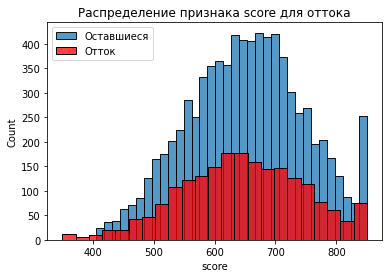

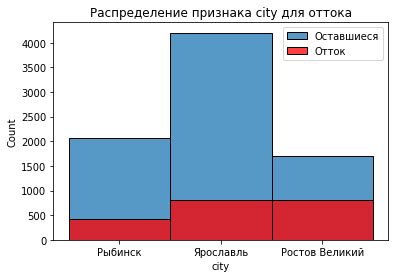

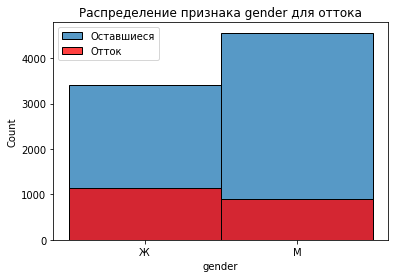

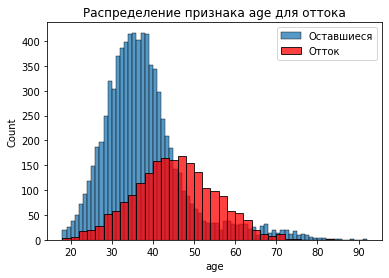

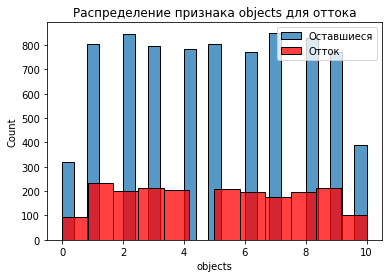

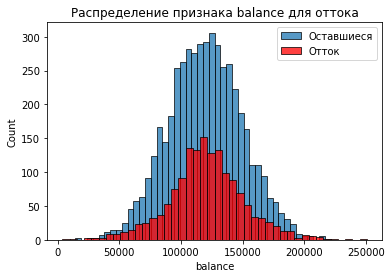

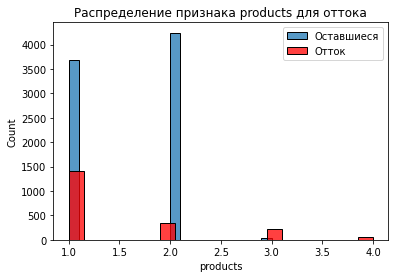

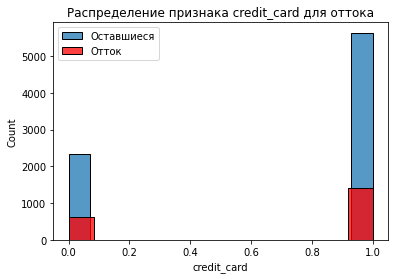

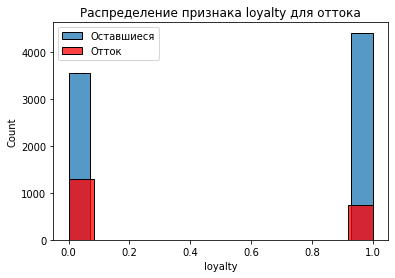

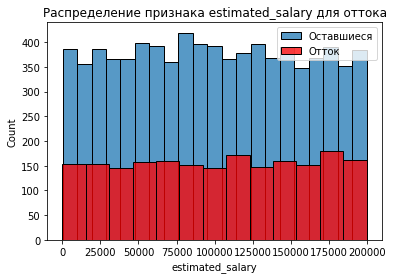

In [10]:
# напишем цикл для отрисовки признаков оставшихся и ушедших клиентов
for col in data.drop(columns={'churn','user_id'}).columns:
    sns.histplot(data=data, x=data.query('churn==0')[col])
    plt.title('Распределение признака {} для оставшихся клиентов'.format(col))
    #plt.show()
    sns.histplot(data=data, x=data.query('churn==1')[col], color='red')
    plt.title('Распределение признака {} для оттока'.format(col))
    plt.legend(['Оставшиеся','Отток'])
    plt.show()

Распределение большинства величин близко к нормальному.

Отток клиентов наблюдается в возрастном диапазоне от 40 и до 55, а основные действующие клиенты превалюруют в диапазоне 25-40. Также наблюдается очень сильная тенденция оттока(почти 100%) у клиентов с 3 и 4 продуктами. Оттекают и клиенты с 1 продуктом, но их доля не составляет больше 40%. Отток клиентов из Ростова Великого почти 50%, чем-то клиенты недовольны

Чаще уходят не лояльные клиенты и клиенты с кредитными картами. Заработная плата не отражает никакого влияния на отток клиентов.

In [11]:
# Приведем тип данных к integer, чтобы признак участвовал в матрице корреляций и в дальнейшем рассмотрении
data['gender'] = data['gender'].replace({'М':1,'Ж':0})

Принято решение удалить пропущенные значения, хоть и доля пропусков велика, но заполнение их без привязки к чему-то или знания причины может вызвать искажение данных и результатов предсказаний и кластеризации

In [12]:
#Удалим пропущенные значения
data = data.dropna()

In [13]:
# посмотрим среднее по оттоку и оставшимся
round(data.drop(columns={'user_id'}).groupby('churn').mean().T, 2)

churn,0,1
score,652.82,645.84
gender,0.58,0.45
age,37.42,44.81
objects,4.98,4.97
balance,119535.86,120746.97
products,1.36,1.47
credit_card,0.70,0.70
loyalty,0.56,0.36
estimated_salary,100512.65,101362.75


Из данных видно, что оттекают чаще не лояльные клиенты и более взрослые

Были испробованы разные варианты преобразования столбца с городом, но остановимся на варианте перекодировки.

In [14]:
#data = pd.get_dummies(data)
#data.head()

# data =data.drop(columns={'city'})

from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder() # создаём переменную класса LabelEncoder - кодировщик
data['city'] = encoder.fit_transform(data['city'])

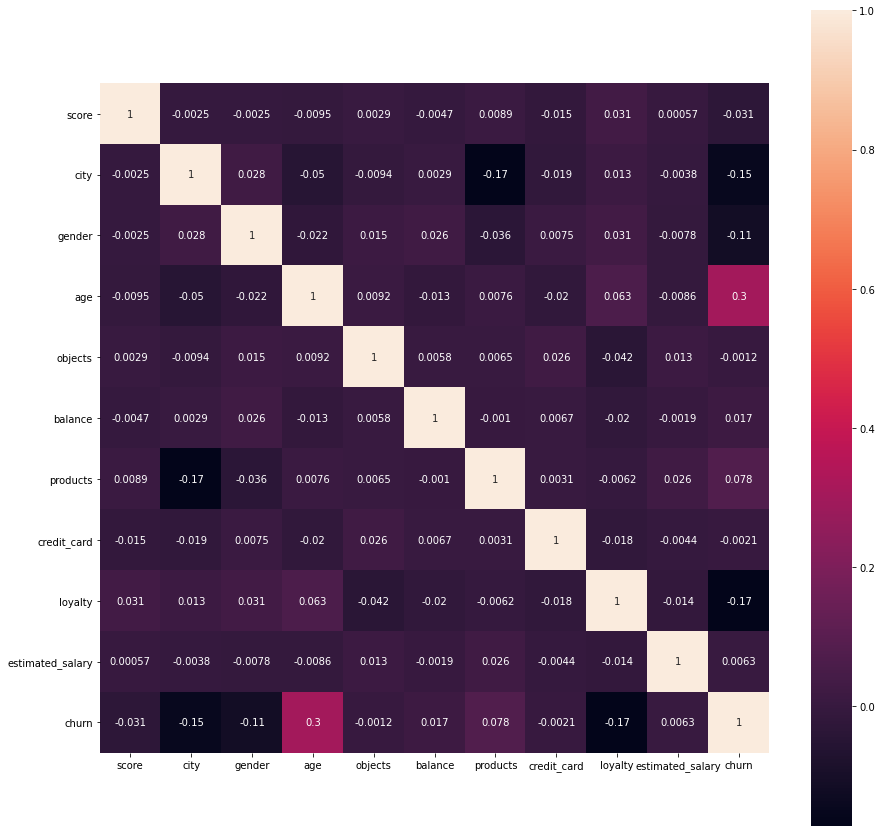

In [15]:
# матрица корреляций, представленная тепловой картой
plt.figure(figsize=(15,15))
sns.heatmap(data=data.drop(columns={'user_id'}).corr(),square=True, annot=True)
plt.show()

Признак возраста коррелирует с целевой переменной. А лояльность и пол имеют слабую отрицательную корреляцию к оттоку.

### Вывод
Основные факторы вляющие на отток это возраст, количество продуктов и город, а также слабо влияет лояльность и кредитная карта
По средним видно, что имеются различия в возрасте и лояльности, их влияние и потребуется дополнительно исследовать

## Обучение модели предсказания

In [16]:
# разделяем модель на обучающую и валидационную выборку
X = data.drop(columns=(['churn','user_id']),axis=1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Проверим результат деления выборок
X_train.shape

(5106, 10)

In [17]:
# обозначим список моделей которые будем обучать
models = [
    LogisticRegression(random_state=0,solver='liblinear'),
    RandomForestClassifier(random_state=0)
]

# функция, которая принимает на вход модель и данные и выводит метрики 
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} R2:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            r2_score(y_test, y_pred),
        )
    )

In [18]:
# цикл для прогонки моделей и получения метрик по ним
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(random_state=0, solver='liblinear')
Accuracy:0.78 Precision:0.46 Recall:0.10 R2:-0.30 
RandomForestClassifier(random_state=0)
Accuracy:0.85 Precision:0.75 Recall:0.48 R2:0.13 


Показатели моделей не лучшие, но и с данными не все так гладко. 

## Кластеризация клиентов

In [19]:
# стандартизация данных
sc = StandardScaler()
X_sc = sc.fit_transform(X)

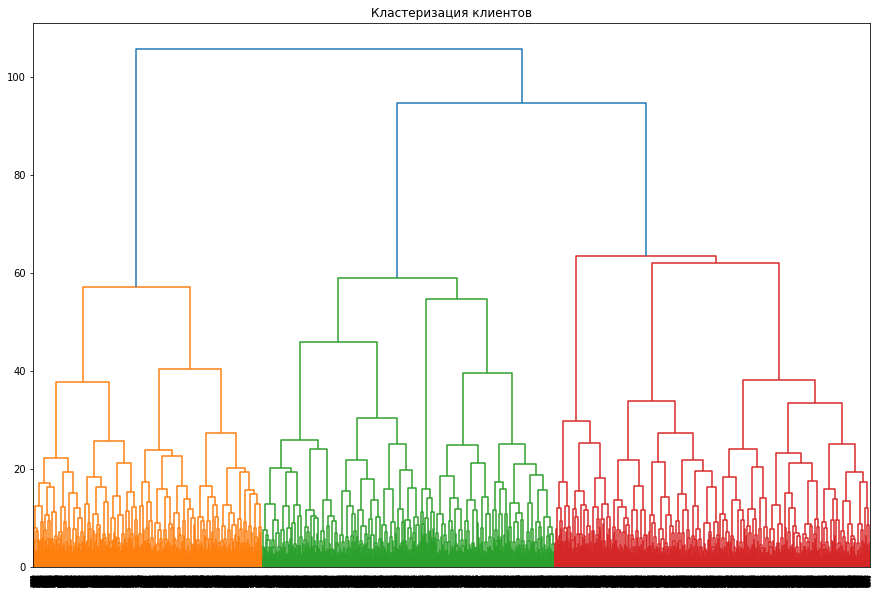

In [20]:
# отрисовка дендограммы
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

Предположительно можно выделить 5 кластеров пользователей

In [21]:
# задаем модель и обучаем ее
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
data['cluster_km'] = labels

In [22]:
# выводим статистику по средним значениям признаков по кластеру
display(round(data.groupby('cluster_km').mean().T,2))

cluster_km,0,1,2,3,4
user_id,15736314.86,15730113.94,15733977.18,15730979.65,15734643.55
score,653.97,647.00,649.84,655.93,647.26
city,1.05,1.23,0.92,1.33,0.29
gender,0.55,0.55,0.52,0.58,0.53
age,36.94,37.48,60.54,34.98,38.02
objects,4.87,5.08,4.95,4.87,5.17
balance,119171.11,121162.15,119971.20,119205.49,119646.95
products,1.34,1.12,1.21,1.15,2.23
credit_card,0.00,1.00,0.73,1.00,0.95
loyalty,0.49,0.00,0.81,1.00,0.48


Кластеры распределены довольно равномерно и выделить превалирующий тяжело

In [23]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.09


Дополнительная оценка класетризации пригодится. Значение не такое уж и плохое, учитывая, что нет явной структуры данных, из которой можно выделить определенные кластеры

In [24]:
print('доля оттока для кластеров',round(data.groupby('cluster_km')['churn'].count()/len(data)*100))

доля оттока для кластеров cluster_km
0    26.0
1    24.0
2    10.0
3    22.0
4    17.0
Name: churn, dtype: float64


### Вывод
Наиболее оттекающие кластеры как оказались это 1 и 3. И как раз таки у них средний показатель лояльности у одного кластера есть кредитная карта, а у другого нет. Так и среднее по продуктам выше. 

## Проверка статистических гипотез

<b>В обоих гипотезах будем проверять связь при помощи ttest_ind, для двух независимых выборок, с параметром equal_var=False, т.к. неизвестно равны ли дисперсии и размер выборок различный

<b>Гипотеза о различии среднего дохода между группами</b>

Нулевая гипотеза: различий в среднем доходе между группами нет.

Альтернативная гипотеза: различия в среднем доходе между группами есть.

Уровень статистической значимости: <b>0.05</b>

In [25]:
st.ttest_ind(data.query('churn==0')['estimated_salary'], data.query('churn==1')['estimated_salary'], equal_var=False).pvalue

0.6150083070259462

Полученное P-value не позволяет отклонить нулевую гипотезу ( 0.05<0.61 ). Следовательно, различия в доходе нет. Сравним средние значения выборки.

In [26]:
print('Средняя зарплата отставшихся клиентов =', round(data.query('churn==0')['estimated_salary'].mean(),3))
print('Средняя зарплата оттекших клиентов =', round(data.query('churn==1')['estimated_salary'].mean(),3))

Средняя зарплата отставшихся клиентов = 100512.654
Средняя зарплата оттекших клиентов = 101362.746


Разница практически отсутствует, различие в 800 единиц при таких показателях несущественна

<b>Гипотеза об отсутствии различий в по возрасту между группами</b>

Нулевая гипотеза: различий в среднем возрасте между группами нет. 

Альтернативная гипотеза: различия в среднем возрасте между группами есть.

Уровень статистической значимости: <b>0.05</b>

In [27]:
st.ttest_ind(data.query('churn==0')['age'], data.query('churn==1')['age'], equal_var=False).pvalue

2.0221492438129482e-129

Полученное P-value позволяет отклонить нулевую гипотезу ( 0.05>0 ). Следовательно, различия в возрасте групп имеются и серьезные. Сравним средние значения выборки.

In [28]:
print('Средний возраст отставшихся клиентов =', round(data.query('churn==0')['age'].mean(),1))
print('Средний возраст оттекших клиентов =', round(data.query('churn==1')['age'].mean(),1))

Средний возраст отставшихся клиентов = 37.4
Средний возраст оттекших клиентов = 44.8


Чувствуется серьезная разница в возрасте, различия около 8 лет и по предыдущим данным было видно, что как раз таки уходят люди старше 40 лет все больше и больше

# Общий вывод и рекомендации
Проведена предобработка данных, типы данных привидены к стандарту. Удалены пропуски, некоторые столбцы преобразованы для дальнейшей работы. Дубликатов не обнаружено. Проведен исследовательский анализ, построены графики распределения величин, тепловая карта корреляций. Обучена модель машинного обучения и кластеризованы пользователи на несколько сегментов и выявлен потрет наиболее склонных к уходу клиентов.

По собранным данным и подтвержденным гипотезам, можно сказать, что отток примерно равносильный во всех городах. Отток подвержен возрастному периоду начиная от 40 и до 55. Наличие кредитной карты не так сильно играет роль для оттекающих клиентов. Лояльность значимо влияет на оттекаемость. Важно заметить, клиенты с 2 продуктами самые устойчивые. Такие факторы как заработная плата и баланс никак не влияют на отток. Клиенты женского пола более часто уходят. Также влияет географический фактор в Ростове Великом уходит почти 50% клиентов.

Сегмент оттока:
* средний возраст 45 лет
* Проживает Ростове Великом, либо же Ярославль
* Около 70% этих клиентов имеют кредитную карту
* Имеют низкую активность
* В среднем 5 объектов в собственности
* В среднем оформлено 1,5 продукта
* Женский пол превалирует над мужским, 55% и 45% соответственно
* Кредитный рейтинг в среднем схож с оставшимися

Рекомендации:
* Проработать удержание клиентов в возрасте 40-55, возможное решение специализированное предложение клиентам с 1 продуктом или более, вклад под повышенный процент или же открытие инвестиционного портфеля с пониженными рисками (спец. стратегией).
* Возможно пользователям не нравится оформление или какие-то лозунги, женская пол чаще уходит из банка, может амбасадор наскучил или надо добавить чего-то более приятного женщинам, те же акции или кэшбэк в какой-нибудь праздник, может список магазинов увеличить с повышенным кэшбэком
* Пересмотреть отношение к клиентам с 3 и более продуктами, там отток выше 90%. Возможно что-то не так с технической поддержкой, возможно их не устраивает стоимость обслуживания такого количества продуктов. Клиентов всегда нужно подстегивать оставаться у банка на более выгодных условиях.